In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
df_combined = pd.read_csv('/content/drive/My Drive/Human vs AI Generated Text Classification/df_combined.csv')

In [ ]:
df_combined

,text,label,length_chars,length_words,punctuation_ratio,repetition_score
0,"As someone who follows food, I believe privacy...",0,126,22,0.031746,0.045455
1,Analysis indicates that travel is associated w...,1,141,19,0.014184,0.000000
2,I recently experienced education in my day-to-...,0,112,17,0.026786,0.000000
3,Analysis indicates that sports is associated w...,1,101,14,0.009901,0.000000
4,"In my experience, finance often leads to users...",0,78,14,0.025641,0.000000
...,...,...,...,...,...,...
20872,The impact of technology on art is an interest...,1,2287,352,0.010494,0.281250
20873,Distance learning has been rapidly growing in ...,1,943,147,0.015907,0.299320
20874,People don't have own decision because they li...,0,2406,434,0.012053,0.767281
20875,How would you feel if your principle told you ...,0,2406,434,0.018703,0.559908


In [ ]:
pip install transformers torch scikit-learn

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.optim import AdamW # Corrected import for AdamW
from tqdm.notebook import tqdm

# Set device to GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [ ]:
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [ ]:
# Tokenize the 'text' column
encodings = tokenizer(df_combined['text'].tolist(), truncation=True, padding=True, max_length=512, return_tensors='pt')

# Prepare labels
labels = torch.tensor(df_combined['label'].tolist())

# Create a TensorDataset
dataset = TensorDataset(encodings['input_ids'], encodings['attention_mask'], labels)

# Split data into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

# Create DataLoaders
batch_size = 64

train_dataloader = DataLoader(train_dataset,
                              sampler = RandomSampler(train_dataset), # Select batches randomly
                              batch_size = batch_size) # Trains with this batch size

val_dataloader = DataLoader(val_dataset,
                            sampler = SequentialSampler(val_dataset), # Sequences batches for evaluation
                            batch_size = batch_size) # Evaluates with this batch size

In [ ]:
optimizer = AdamW(model.parameters(), lr=5e-5)
epochs = 20

In [ ]:
train_losses = []
val_accuracies = []
val_precisions = []
val_recs = []
val_f1s = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(train_dataloader, desc=f"Training Epoch {epoch+1}"):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)
    print(f"Average training loss: {avg_train_loss:.2f}")

    # Validation phase
    model.eval()
    predictions, true_labels = [], []
    for batch in tqdm(val_dataloader, desc=f"Validation Epoch {epoch+1}"):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)

        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)

        logits = outputs.logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        predictions.extend(np.argmax(logits, axis=1).flatten())
        true_labels.extend(label_ids.flatten())

    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary')

    val_accuracies.append(accuracy)
    val_precisions.append(precision)
    val_recs.append(recall)
    val_f1s.append(f1)

    print(f"Validation Accuracy: {accuracy:.2f}")
    print(f"Validation Precision: {precision:.2f}")
    print(f"Validation Recall: {recall:.2f}")
    print(f"Validation F1-score: {f1:.2f}")

Training Epoch 1:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.09


Validation Epoch 1:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.98
Validation Precision: 0.97
Validation Recall: 1.00
Validation F1-score: 0.98


Training Epoch 2:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.01


Validation Epoch 2:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.97
Validation Precision: 0.94
Validation Recall: 1.00
Validation F1-score: 0.97


Training Epoch 3:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.01


Validation Epoch 3:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 1.00
Validation Recall: 0.99
Validation F1-score: 0.99


Training Epoch 4:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.01


Validation Epoch 4:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 5:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 5:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.98
Validation Precision: 0.97
Validation Recall: 1.00
Validation F1-score: 0.98


Training Epoch 6:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.01


Validation Epoch 6:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.98
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 7:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 7:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 8:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 8:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.98
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 9:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 9:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 10:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 10:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 11:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.01


Validation Epoch 11:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 0.98
Validation F1-score: 0.99


Training Epoch 12:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.01


Validation Epoch 12:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 13:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 13:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 14:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 14:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 15:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 15:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 16:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 16:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 17:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 17:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 18:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 18:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 19:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 19:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


Training Epoch 20:   0%|          | 0/261 [00:00<?, ?it/s]

Average training loss: 0.00


Validation Epoch 20:   0%|          | 0/66 [00:00<?, ?it/s]

Validation Accuracy: 0.99
Validation Precision: 0.99
Validation Recall: 1.00
Validation F1-score: 0.99


**Visualizing Training Progress**
I will visualize the training loss and validation metrics (accuracy, precision, recall, F1-score) over the training epochs. This will help us understand the model's performance and convergence during training.

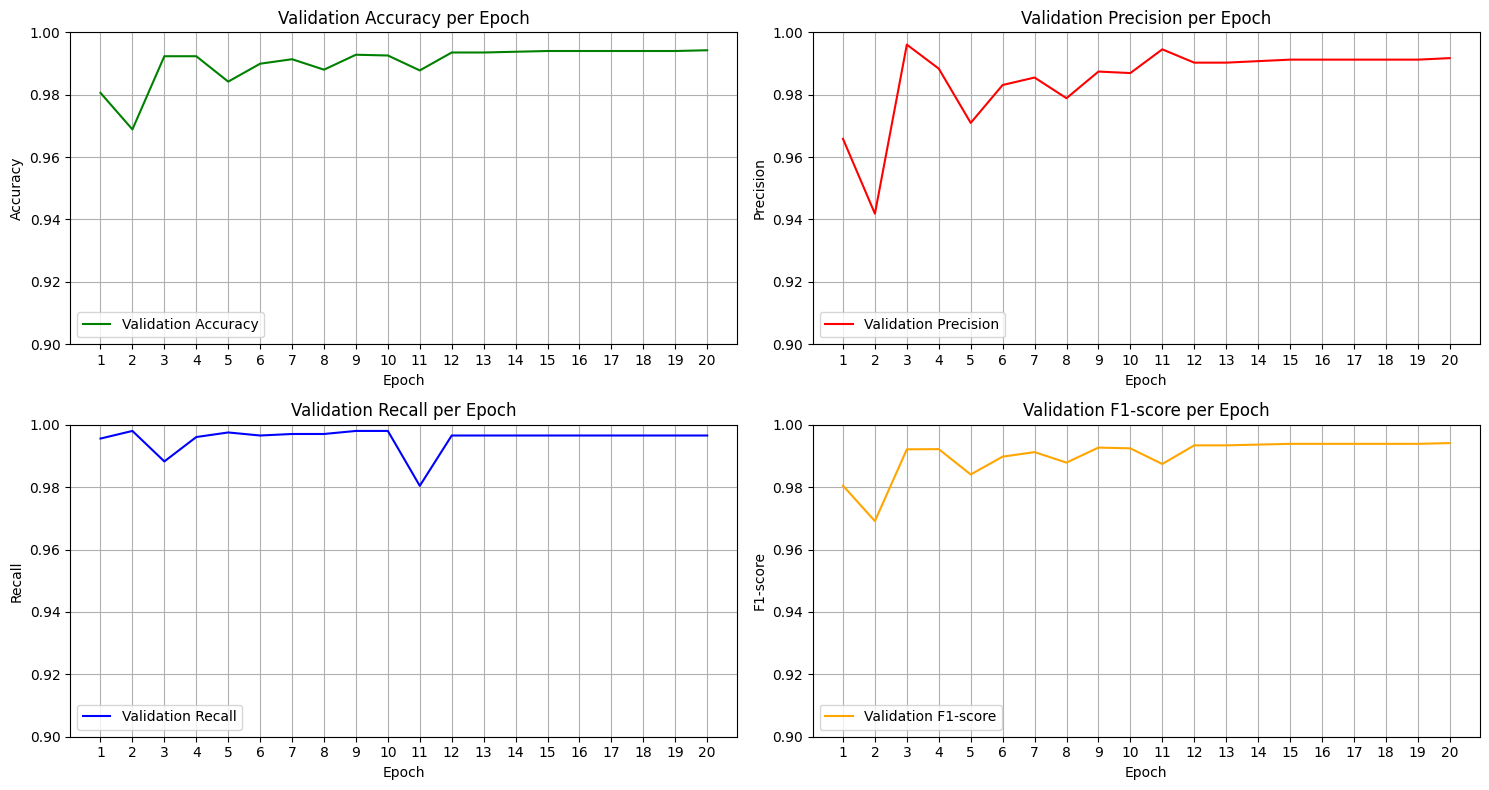

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

epochs_range = range(1, epochs + 1)

plt.figure(figsize=(15, 8))

metrics = [
    (val_accuracies, 'Validation Accuracy', 'Accuracy', 'green'),
    (val_precisions, 'Validation Precision', 'Precision', 'red'),
    (val_recs, 'Validation Recall', 'Recall', 'blue'),
    (val_f1s, 'Validation F1-score', 'F1-score', 'orange')
]

for i, (data, title, ylabel, color) in enumerate(metrics):
    plt.subplot(2, 2, i + 1)
    plt.plot(epochs_range, data, '-', label=title, color=color)
    plt.title(f'{title} per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.ylim(0.90, 1.00)
    plt.xticks(epochs_range)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

**Plotting the ROC Curve**

To further evaluate the model's performance, especially its ability to distinguish between classes, we will plot the Receiver Operating Characteristic (ROC) curve and calculate the Area Under the Curve (AUC).

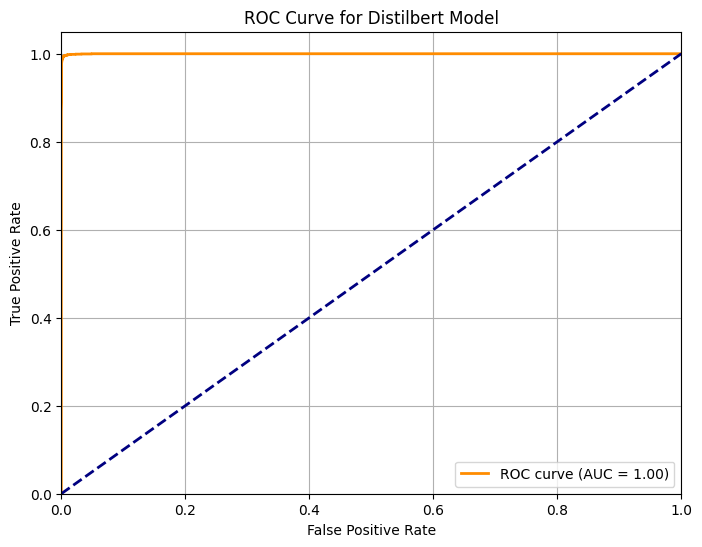

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

model.eval()
all_logits = []
all_labels = []

for batch in tqdm(val_dataloader, desc="Collecting predictions for ROC curve"):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits.detach().cpu()
    all_logits.append(logits)
    all_labels.append(labels.cpu())

all_logits = torch.cat(all_logits, dim=0)
all_labels = torch.cat(all_labels, dim=0)

# Convert logits to probabilities using softmax
probabilities = torch.nn.functional.softmax(all_logits, dim=1)[:, 1].numpy() # Get probability of the positive class (label 1)
true_labels_roc = all_labels.numpy()

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(true_labels_roc, probabilities)
auc_score = roc_auc_score(true_labels_roc, probabilities)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Distilbert Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

**Plotting the Confusion Matrix**

To understand the types of errors our model is making, we will plot a Confusion Matrix. This matrix will visually represent the number of true positive, true negative, false positive, and false negative predictions made by the model on the validation set.

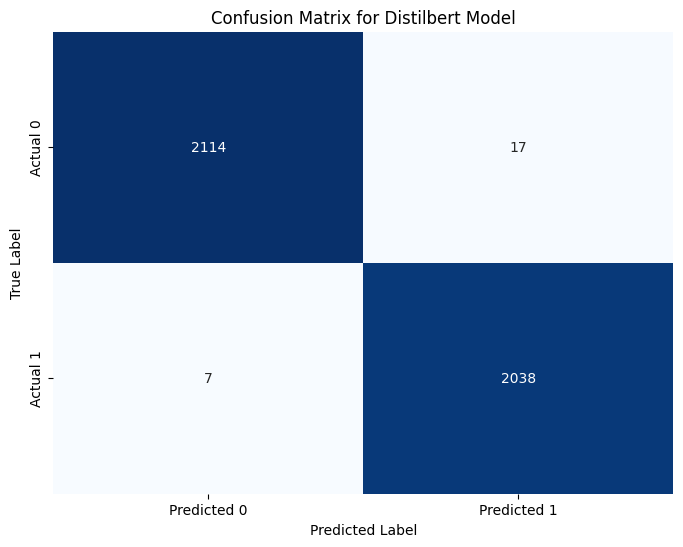

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

model.eval()
predictions = []
true_labels = []

for batch in tqdm(val_dataloader, desc="Collecting predictions for Confusion Matrix"):
    input_ids = batch[0].to(device)
    attention_mask = batch[1].to(device)
    labels = batch[2].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)

    logits = outputs.logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    predictions.extend(np.argmax(logits, axis=1).flatten())
    true_labels.extend(label_ids.flatten())

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Distilbert Model')
plt.show()

**Saving the Trained DistilBERT Model**

In [ ]:
# Define the directory to save the model and tokenizer
output_dir = '/content/drive/My Drive/Human vs AI Generated Text Classification/Distilbert/'

# Save the fine-tuned model
model.save_pretrained(output_dir)

# Save the tokenizer
tokenizer.save_pretrained(output_dir)

print(f"Model and tokenizer saved to {output_dir}")

Model and tokenizer saved to /content/drive/My Drive/Human vs AI Generated Text Classification/Distilbert/
